In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
train_df = pd.read_csv('./Dataset/training_data_v12.csv', encoding="latin1")
test_df = pd.read_csv('./Dataset/test_data_v12.csv',encoding="latin1")

In [151]:
y = train_df['AVERAGE_SPEED_DIFF']
X = train_df.drop(columns=['AVERAGE_SPEED_DIFF'])

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliação
y_pred = rf_model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

rf_importances = rf_model.feature_importances_
print(rf_importances)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

Validation Accuracy: 0.7960
[0.06800822 0.1599042  0.03654467 0.02180973 0.03125488 0.02541894
 0.02203304 0.01912387 0.0075459  0.00821702 0.00640883 0.02551848
 0.00802953 0.00556074 0.00133458 0.04372919 0.04039454 0.01890192
 0.01000546 0.18579864 0.08783993 0.16661768]


## NÃO ESQUECER DE METER AS OUTRAS METRICAS PARA O RELATORIO COMO F1SCORE, MATRIZ DE CONFUSAO, ETC

## Global interpretation

### Mean feature importance (MDI) - Model specific (random forest)

In [142]:
mdi_importances = pd.Series(rf_model.feature_importances_, index=X_val.columns)
print("Feature importances using MDI:\n", mdi_importances)

Feature importances using MDI:
 AVERAGE_FREE_FLOW_SPEED     0.068008
AVERAGE_TIME_DIFF           0.159904
AVERAGE_FREE_FLOW_TIME      0.036545
LUMINOSITY                  0.021810
AVERAGE_TEMPERATURE         0.031255
AVERAGE_ATMOSP_PRESSURE     0.025419
AVERAGE_HUMIDITY            0.022033
AVERAGE_WIND_SPEED          0.019124
AVERAGE_PRECIPITATION       0.007546
AVERAGE_CLOUDINESS          0.008217
year                        0.006409
day                         0.025518
IS_WEEKEND                  0.008030
IS_AUGUST                   0.005561
IS_HOLIDAY                  0.001335
hour_sin                    0.043729
hour_cos                    0.040395
weekday_sin                 0.018902
weekday_cos                 0.010005
Congestion_Factor           0.185799
AVERAGE_TIME_DIFF_x_HOUR    0.087840
AVERAGE_TIME_DIFF_SQR       0.166618
dtype: float64


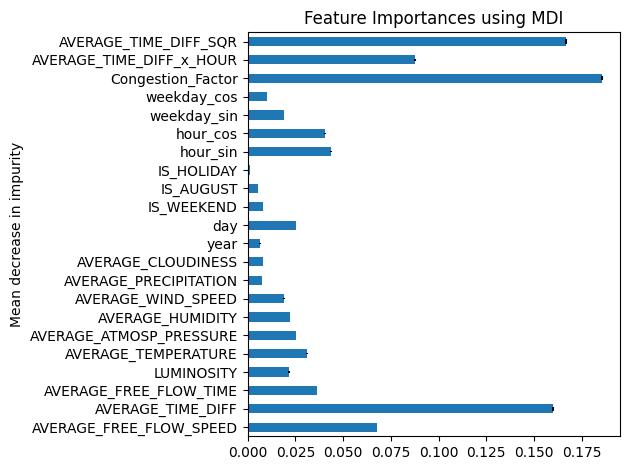

In [143]:
fig, ax = plt.subplots()
mdi_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Permutation importance (PI) - Model agnostic (no need to retrain the model)

In [144]:
result = permutation_importance(rf_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)
p_importances = pd.Series(result.importances_mean, index=X_val.columns)
print("Feature importance using PI:\n", p_importances)

Feature importance using PI:
 AVERAGE_FREE_FLOW_SPEED     0.033969
AVERAGE_TIME_DIFF           0.013720
AVERAGE_FREE_FLOW_TIME      0.009831
LUMINOSITY                  0.005796
AVERAGE_TEMPERATURE         0.004622
AVERAGE_ATMOSP_PRESSURE    -0.000147
AVERAGE_HUMIDITY            0.003448
AVERAGE_WIND_SPEED          0.003302
AVERAGE_PRECIPITATION       0.002788
AVERAGE_CLOUDINESS          0.000293
year                        0.002128
day                         0.001981
IS_WEEKEND                  0.003962
IS_AUGUST                   0.004622
IS_HOLIDAY                  0.000807
hour_sin                    0.016141
hour_cos                    0.009758
weekday_sin                 0.003228
weekday_cos                 0.000954
Congestion_Factor           0.052751
AVERAGE_TIME_DIFF_x_HOUR    0.011079
AVERAGE_TIME_DIFF_SQR       0.017755
dtype: float64


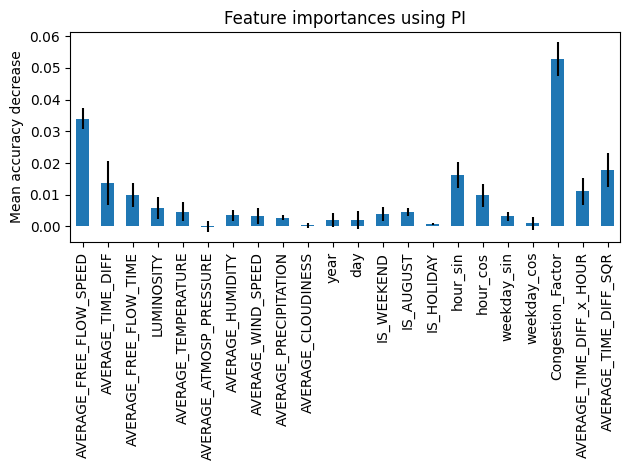

In [145]:
fig, ax = plt.subplots()
p_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using PI")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### SelectKBest

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecionar top K features
# Ajusta k conforme necessário (10, 15, 20)
selector = SelectKBest(f_classif, k=8)

# Fit no treino
X_train_selected = selector.fit_transform(X_train, y_train)

# Transformar validação (e teste se necessário)
X_val_selected = selector.transform(X_val)
# Se quiseres aplicar ao test_df também:
# X_test_selected = selector.transform(test_df)

# Ver quais foram selecionadas
cols = X_train.columns.tolist()
selected_features = [cols[i] for i in selector.get_support(indices=True)]
print("Features que mais relevância tiveram no treino:", selected_features)

Features que mais relevância tiveram no treino: ['AVERAGE_FREE_FLOW_SPEED', 'AVERAGE_TIME_DIFF', 'LUMINOSITY', 'AVERAGE_TEMPERATURE', 'AVERAGE_HUMIDITY', 'IS_WEEKEND', 'hour_sin', 'hour_cos']


## SHAP Analysis - Local Interpretation

### Se quiserem fazer para o relatorio para justificar de que forma as features influenciam a decisao do modelo, como o output do modelo varia com cada variação dos valores de cada feature (se a AVERAGE_CLOUDINESS passar de 1 para 2 por exemplo)

In [8]:
rf_full = RandomForestClassifier(n_estimators=200, random_state=42)
rf_full.fit(X, y)

test_preds = rf_full.predict(test_df)

target_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
rev_target_map = {v: k for k, v in target_map.items()}

test_preds_labels = [rev_target_map[p] for p in test_preds]

submission = pd.DataFrame({
    'RowId': range(1, len(test_preds_labels) + 1),
    'Speed_Diff': test_preds_labels
})

submission.to_csv('submission.csv', index=False)
print("Ficheiro submission.csv criado com sucesso.")

Ficheiro submission.csv criado com sucesso.
